In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().parent.resolve().parent.resolve()))
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import models

In [2]:
cnn_checkpoint = torch.load('../pretrained_models/enhancers_and_silencers/epi-cnn/checkpoints/epoch=999-step=20000.ckpt')
graph_checkpoint = torch.load('../pretrained_models/enhancers_and_silencers/epi-graphreg/checkpoints/epoch=999-step=20000.ckpt')

In [3]:
epi_cnn = models.EpiCNN(1,1)
epi_graph_reg = models.EpiGraphReg(1,1)

In [4]:
epi_cnn.load_state_dict(cnn_checkpoint['state_dict'])
epi_graph_reg.load_state_dict(graph_checkpoint['state_dict'])

<All keys matched successfully>

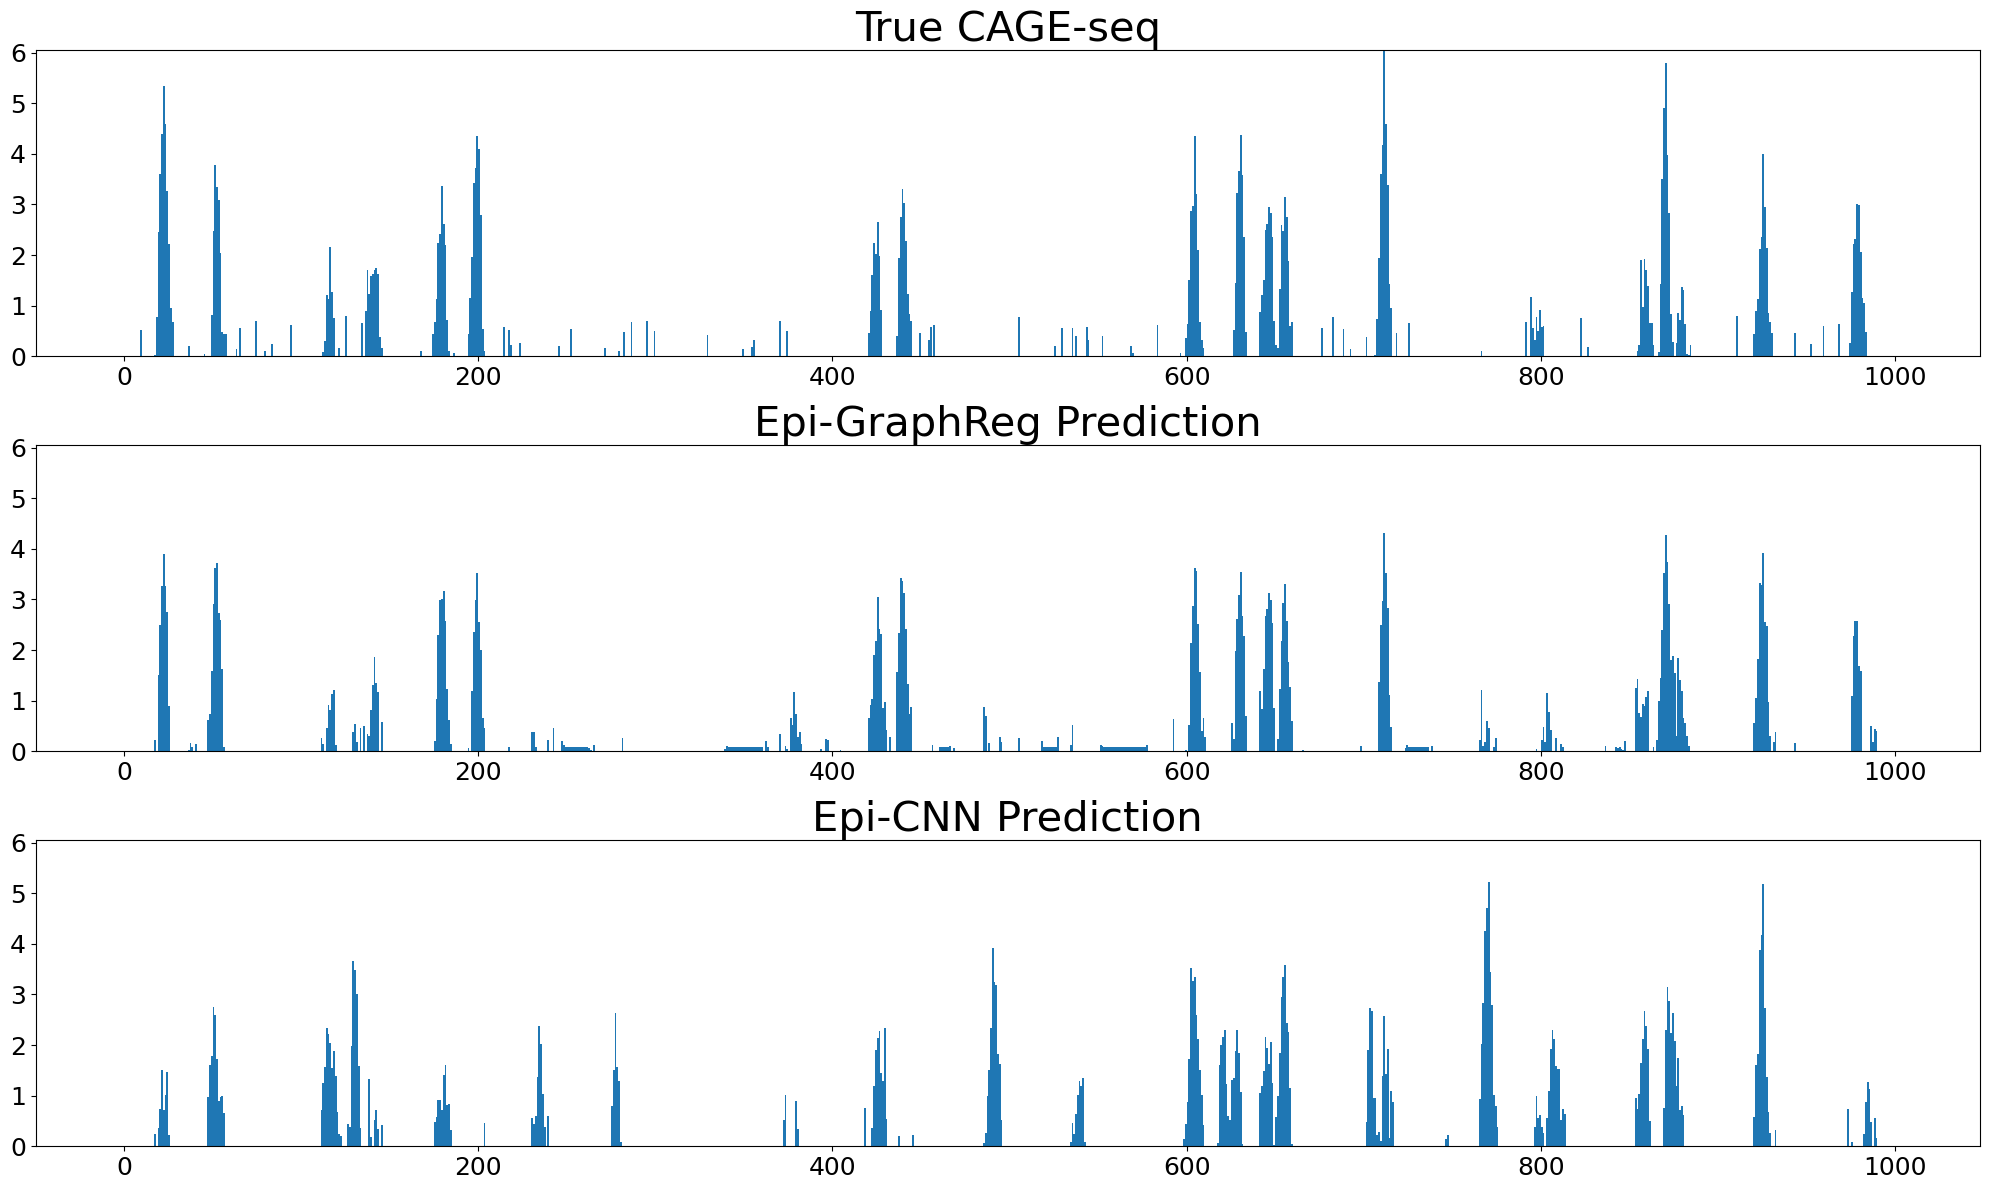

In [5]:
ch = torch.load('../data/enhancers_and_silencers/test_data/chromosome_1.pt')
dnase = ch['dnase_seq']
cage = ch['cage_seq']
g = ch['edges']

with torch.no_grad():
    pred_cage_cnn = epi_cnn(dnase.unsqueeze(0))
    pred_cage_egr = epi_graph_reg(dnase.unsqueeze(0), g)

bins = range(len(dnase))

# plt.figure(figsize=(20,2))
# plt.hist(bins, bins[:-1], weights = dnase)
# plt.title('DNase-seq', fontsize=20)

plt.figure(figsize=(20,12))
plt.subplot(311)
plt.hist(bins, bins[:-1], weights = cage)
plt.title('True CAGE-seq', fontsize=30)
plt.ylim(0, cage.max())
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.figure(figsize=(20,2))
plt.subplot(312)
plt.hist(bins, bins[:-1], weights = pred_cage_egr.detach().squeeze())
plt.title('Epi-GraphReg Prediction', fontsize=30)
plt.ylim(0, cage.max())
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.figure(figsize=(20,2))
plt.subplot(313)
plt.hist(bins, bins[:-1], weights = pred_cage_cnn.detach().squeeze())
plt.ylim(0, cage.max())
plt.title('Epi-CNN Prediction', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.savefig('PredictionComparisonEandS.eps', bbox_inches='tight')

(0.0, 1000.0)

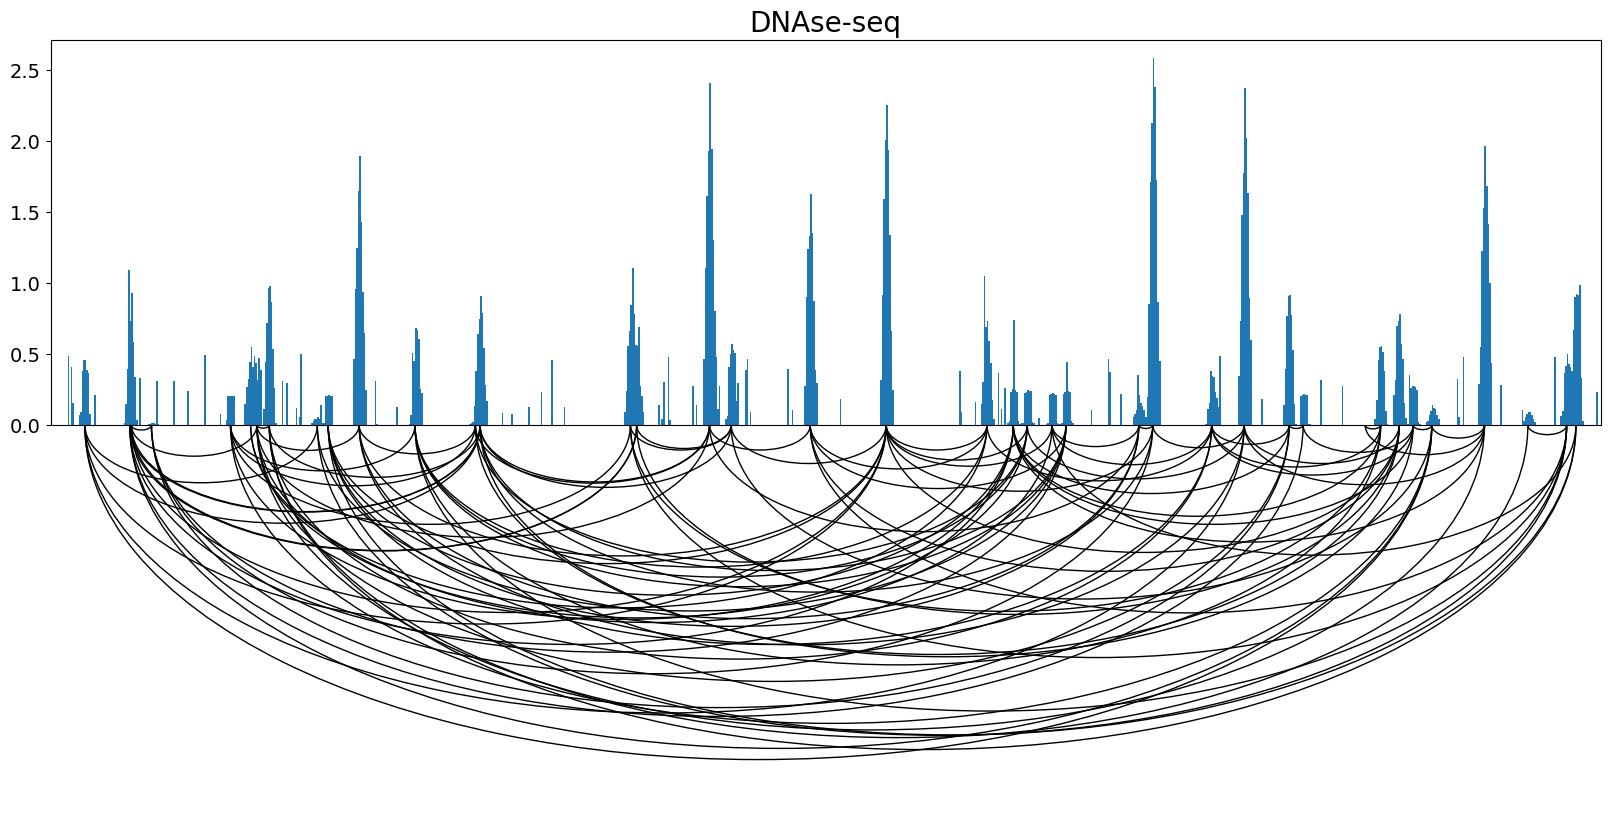

In [6]:
# https://stackoverflow.com/questions/54507499/i-am-trying-to-make-a-arc-diagram-using-python-but-i-am-not-able-to-get-the-heig

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import patches


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

# plt.figure(figsize=(20,2))
ax1.hist(bins, bins[:-1], weights = dnase)
ax1.set_xlim(0,1000)
ax1.set_title('DNAse-seq', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xticks([])
# plt.show()

for e in g.T:
    
    x1, x2 = e.numpy()
    y1, y2 = 0, 0

    # calculate the arc
    mxmy = (mx, my) = ((x1 + x2) / 2, (y1 + y2) / 2)
    r = np.sqrt((x1 - mx)**2 + (y1 - my)**2)
    width = 2 * r
    height = 2 * r/100
    start_angle = np.arctan2(y1 - my, x1 - mx) * 180 / np.pi
    end_angle = np.arctan2(my - y2, mx - x2) * 180 / np.pi
    
    # draw
    arc = patches.Arc(mxmy, width, height, theta1=180, theta2=0)

    ax2.add_patch(arc)
    
plt.subplots_adjust(hspace=0)

ax2.axis('off')
ax2.set_ylim(-5, 0)
plt.xlim(0,1000)
# plt.tight_layout()
# plt.savefig('DNAse.eps', bbox_inches='tight')

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7')])

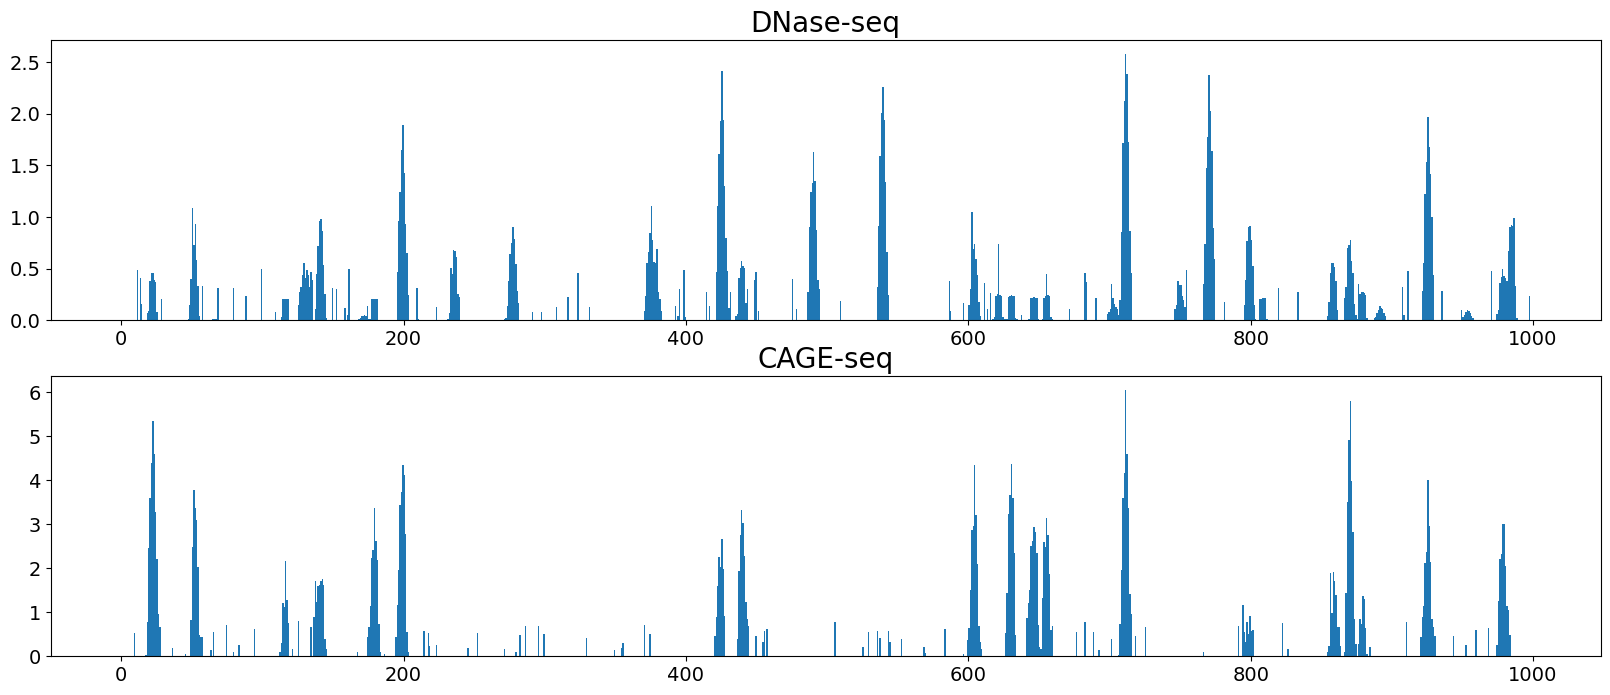

In [7]:
plt.figure(figsize=(20,8))

plt.subplot(211)
plt.hist(bins, bins[:-1], weights = dnase)
plt.title('DNase-seq', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.subplot(212)
plt.hist(bins, bins[:-1], weights = cage)
plt.title('CAGE-seq', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.ylim(0, cage.max())
# plt.tight_layout()
# plt.savefig('DNAseAndCAGE.eps', bbox_inches='tight')

In [8]:
cnn_mse = 0
graph_mse = 0
cnn_mse_roi = 0
graph_mse_roi = 0

for i in range(1, 6):
    ch = torch.load(f'../data/enhancers_and_silencers/test_data/chromosome_{i}.pt')
    dnase = ch['dnase_seq']
    cage = ch['cage_seq']
    g = ch['edges']
    roi = torch.zeros_like(cage)

    for o in range(-3, 2):
        roi[ch['gene_indices']+o] = 1
        # roi[ch['enhancer_indices']+o] = 1
        # roi[ch['silencer_indices']+o] = 1

    with torch.no_grad():
        pred_cage_cnn = epi_cnn(dnase.unsqueeze(0)).squeeze()
        pred_cage_egr = epi_graph_reg(dnase.unsqueeze(0), g).squeeze()

    cnn_mse += F.mse_loss(pred_cage_cnn, cage)/5
    cnn_mse_roi += F.mse_loss(pred_cage_cnn*roi, cage*roi)/5
    graph_mse += F.mse_loss(pred_cage_egr, cage)/5
    graph_mse_roi += F.mse_loss(pred_cage_egr*roi, cage*roi)/5

In [9]:
print(cnn_mse, cnn_mse_roi, graph_mse, graph_mse_roi)

tensor(0.5240) tensor(0.1892) tensor(0.1395) tensor(0.0620)
